In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import re
from tqdm import tqdm 
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('df_english.csv')

In [3]:
df.head(1)

,Id,Price,Address,Nearest_Subway,Publication_date,Num_of_rooms,Total_area,Living_space,Floor,Balcony,...,Cargo_lift,New_building_name,Building,Official_developer,Participation_type,Due_date,Link,Coordinates,WMO,Area
0,105724302,9800000,"Санкт-Петербург, Пушкинский р-н, пос. Шушары, ...",NaN,17.10.2022 в 10:16,3,73 м²,NaN,1 из 5,балкон,...,NaN,NaN,NaN,NaN,NaN,NaN,https://avito.ru//sankt-peterburg/kvartiry/3-k...,"59.737926, 30.461476",Шушары,Пушкинский


In [4]:
df.columns.values.tolist()

['Id',
 'Price',
 'Address',
 'Nearest_Subway',
 'Publication_date',
 'Num_of_rooms',
 'Total_area',
 'Living_space',
 'Floor',
 'Balcony',
 'Room_type',
 'Ceiling_height',
 'Bathroom',
 'Windows',
 'Repair',
 'Furniture',
 'Warm_floor',
 'Decoration',
 'Appliances',
 'Sale_method',
 'Deal_type',
 'House_type',
 'Year_build',
 'Floors_in_house',
 'Passenger_lift',
 'Parking',
 'In_house',
 'Yard',
 'Cargo_lift',
 'New_building_name',
 'Building',
 'Official_developer',
 'Participation_type',
 'Due_date',
 'Link',
 'Coordinates',
 'WMO',
 'Area']

In [5]:
# Сперва удалим неинформативные столбцы и дубликаты.
df = df.drop(['Id', 'Link', 'Official_developer', 
              'New_building_name', 'Building', 'Nearest_Subway'], axis=1)

df = df.drop_duplicates(['Address', 'Total_area', 'Floor'])

# Feature_engineering

### Обработка координат

Ориентироваться на адрес не очень удобно, поэтому этот признак преобразуем в кооридинаты

In [6]:
df[['lat_object', 'lon_object']] = df['Coordinates'].str.split(', ',expand=True).astype('float')

df[['lat_object', 'lon_object']].describe()

,lat_object,lon_object
count,19565.000000,19565.000000
mean,59.675410,30.485540
std,2.044360,3.272827
min,38.552623,-4.719892
25%,59.852538,30.251297
50%,59.931927,30.326360
75%,60.000654,30.406679
max,60.262019,137.986851


Видно, что в данных есть выбросы, не характерные для координат СПб. Ограничив последние диапазоном по широте от 58,7 до 61 град и по долготе от 28,5 до 33,5, введем фильтр.

In [7]:
df[(df['lat_object'] > 61) | (df['lat_object'] < 58.7) | 
   (df['lon_object'] > 33.5) | (df['lon_object'] < 28.5)]['Price'].count()

348

In [8]:
df = df.drop(df[(df['lat_object'] > 61) | (df['lat_object'] < 58.7) | 
   (df['lon_object'] > 33.5) | (df['lon_object'] < 28.5)].index)

In [9]:
#удаляем уже теперь лишние столбцы
df = df.drop(["Coordinates", "Address"], axis=1)

## Добавляем расстояние до метро

Для этого нам понадобится еще один DataFrame с использованием координат местонахождения станций метро. Координаты в процессе работы также были нами спаршены.

In [10]:
path = 'C:/Users/konst/PetProject-price-real-estate-in-St.-Petersburg/parser/metro.csv'
subway_coordinates = pd.read_csv(path)
subway_coordinates.head()

,Станция,Координаты
0,Девяткино,"60.050182, 30.443045"
1,Гражданский проспект,"60.034969, 30.418224"
2,Академическая,"60.012806, 30.396044"
3,Политехническая,"60.008942, 30.370907"
4,Площадь Мужества,"59.999828, 30.366159"


In [11]:
#переименовываем название наших фичей
new_names = [
    "Station", "Coordinates"
 ]
mapper = {key:value for key, value in zip(subway_coordinates.columns.values, new_names)}

subway_coordinates.rename(columns=mapper, inplace=True)

In [12]:
#разделяем коррдинаты станций метро по широте и долготе
subway_coordinates[['lat_subway', 'lon_subway']] = subway_coordinates['Coordinates'].str.split(', ',expand=True).astype('float')

#переводим название станций метро в нижний регистр
subway_coordinates['Station'] = subway_coordinates['Station'].str.lower()

#удаляем уже ненужную фичу 'Station'
subway_coordinates = subway_coordinates.drop('Coordinates', axis=1)

subway_coordinates.head(1)

,Station,lat_subway,lon_subway
0,девяткино,60.050182,30.443045


Следующим шагом создадим функцию для расчета расстояния объекта до каждого метро

In [13]:
def distinator(row, latitiude_fin, longitude_fin):
    '''
    Расчет расстояния в км
    '''
    return round(np.sqrt((row['lat_object'] - latitiude_fin)**2 + 
                        (row['lon_object'] - longitude_fin)**2) * 111.13, 3)

In [14]:
# чтобы функция отработала корректно сбрасываем индексы.
df = df.reset_index(drop=True)

In [15]:
#Вводим расстояние до некоторых, станций. 
stations_names = [
    'комендантский проспект',
    'крестовский остров',
    'шушары',
    'парнас',
    'купчино',
    'улица дыбенко',
    'девяткино',
    'проспект ветеранов',
]
for i in tqdm(stations_names):
    df[i + '_dist'] = df.apply(distinator, 
                            args=(subway_coordinates[subway_coordinates['Station'] == i]['lat_subway'], 
                                    subway_coordinates[subway_coordinates['Station'] == i]['lon_subway']),
                                axis=1
                                )

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:26<00:00, 18.33s/it]


In [16]:
df.head()

,Price,Publication_date,Num_of_rooms,Total_area,Living_space,Floor,Balcony,Room_type,Ceiling_height,Bathroom,...,lat_object,lon_object,комендантский проспект_dist,крестовский остров_dist,шушары_dist,парнас_dist,купчино_dist,улица дыбенко_dist,девяткино_dist,проспект ветеранов_dist
0,9800000,17.10.2022 в 10:16,3,73 м²,NaN,1 из 5,балкон,изолированные,NaN,раздельный,...,59.737926,30.461476,37.586,34.347,9.662,39.223,13.966,18.991,34.761,26.140
1,24000000,17.10.2022 в 01:22,3,85 м²,NaN,3 из 5,NaN,изолированные,NaN,совмещенный,...,59.939086,30.343213,12.163,9.996,16.558,14.252,12.672,15.962,16.599,14.903
2,12500000,22.10.2022 в 10:29,2,55 м²,NaN,8 из 12,лоджия,изолированные,2.6 м,раздельный,...,60.005504,30.254046,0.617,3.791,28.624,11.195,23.751,27.712,21.582,18.162
3,14200000,21.10.2022 в 16:53,1,50 м²,32 м²,17 из 17,балкон,NaN,3.4 м,совмещенный,...,59.935831,30.249087,8.156,4.162,24.129,17.354,18.354,26.220,25.022,10.417
4,5500000,16.10.2022 в 03:52,студия,26 м²,14 м²,9 из 25,балкон,NaN,2.7 м,совмещенный,...,59.838028,30.352169,21.616,18.091,9.174,25.526,2.771,16.488,25.649,11.298


## Обработка целевого признака Price

Попробуем ввести новую переменную основанную на вычеслении квадратных метров.

Для этого изначально обрабатываем необходимые нам фичи.

In [17]:
for i in ['Total_area', 'Living_space', 'Ceiling_height']:
    df[i] = df[i].replace({'no_info': 0})
    df.loc[df[i] != 0, i] = df[i].str.split(' ', expand=True)[0]
    df[i] = df[i].astype('float')

Так как общая площадь стоит в знаменателе при расчете ее стоимости, необходимо исключить объекты с нулевым значением указанного параметра.

In [18]:
df.head()

,Price,Publication_date,Num_of_rooms,Total_area,Living_space,Floor,Balcony,Room_type,Ceiling_height,Bathroom,...,lat_object,lon_object,комендантский проспект_dist,крестовский остров_dist,шушары_dist,парнас_dist,купчино_dist,улица дыбенко_dist,девяткино_dist,проспект ветеранов_dist
0,9800000,17.10.2022 в 10:16,3,73.0,NaN,1 из 5,балкон,изолированные,NaN,раздельный,...,59.737926,30.461476,37.586,34.347,9.662,39.223,13.966,18.991,34.761,26.140
1,24000000,17.10.2022 в 01:22,3,85.0,NaN,3 из 5,NaN,изолированные,NaN,совмещенный,...,59.939086,30.343213,12.163,9.996,16.558,14.252,12.672,15.962,16.599,14.903
2,12500000,22.10.2022 в 10:29,2,55.0,NaN,8 из 12,лоджия,изолированные,2.6,раздельный,...,60.005504,30.254046,0.617,3.791,28.624,11.195,23.751,27.712,21.582,18.162
3,14200000,21.10.2022 в 16:53,1,50.0,32.0,17 из 17,балкон,NaN,3.4,совмещенный,...,59.935831,30.249087,8.156,4.162,24.129,17.354,18.354,26.220,25.022,10.417
4,5500000,16.10.2022 в 03:52,студия,26.0,14.0,9 из 25,балкон,NaN,2.7,совмещенный,...,59.838028,30.352169,21.616,18.091,9.174,25.526,2.771,16.488,25.649,11.298


In [19]:
# заполним пропуски нашего таргета 
df['Total_area'] = df['Total_area'].fillna(df['Total_area'].median())
# выполняем проверку на остаток пропусков
df['Total_area'].isnull().sum()

0

In [20]:
len(df[df['Total_area'] == 0]) / len(df)

0.0

In [21]:
# Вводим новый признак Price_m_2, который будет указывать на стоимость квадратного метра объекта недвижимости.

df = df.drop(df[df['Total_area'] == 0].index)

df['Price_m_2'] = df['Price'] / df['Total_area']

df['Price_m_2'].describe()
     

count    1.921700e+04
mean     2.401975e+05
std      2.147331e+06
min      1.297847e+02
25%      1.641286e+05
50%      1.981481e+05
75%      2.508658e+05
max      2.571429e+08
Name: Price_m_2, dtype: float64

Видим, что тут также присутсвуют выбросы. Для принятия окончательного решения (какую цену использовать) построим вместе графики цены в целом и цены за кв.м.

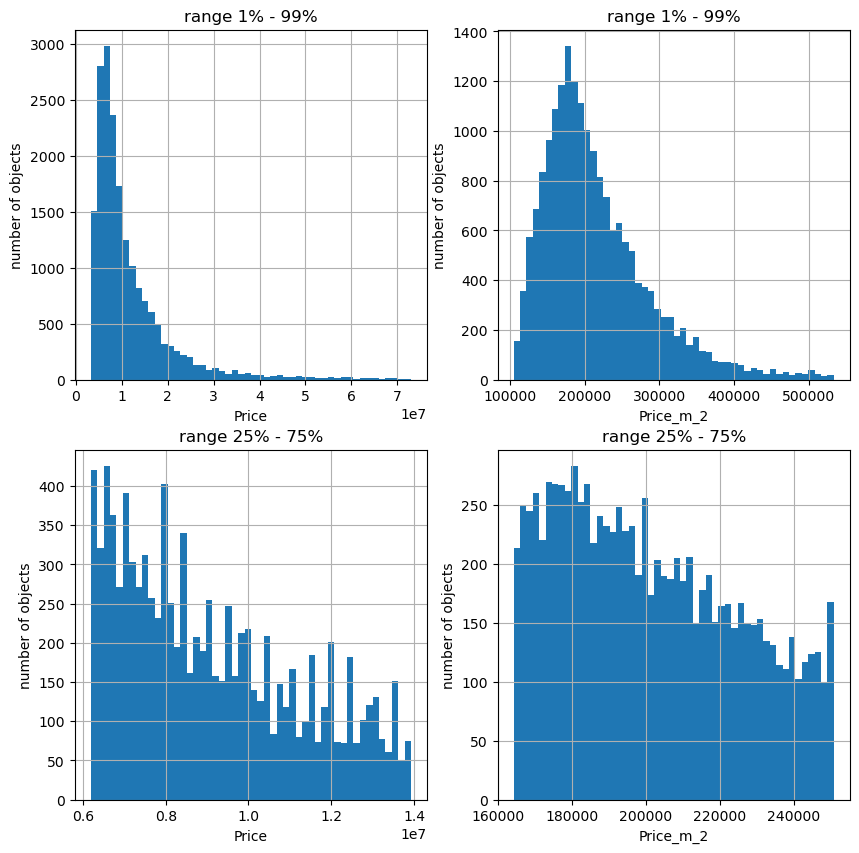

In [22]:
width = 2
height = 2
features = ['Price', 'Price_m_2']
low_perc = [1, 25]
high_perc = [99, 75]

_, axs = plt.subplots(width, height, figsize=(10, 10))
for j in range(width):
    for i in range(height):
        df[(df[features[i]] >= np.percentile(df[features[i]], low_perc[j])) & 
           (df[features[i]] <= np.percentile(df[features[i]], high_perc[j]))
           ][features[i]].hist(bins=50, ax=axs[j, i]) 
        axs[j, i].set_title(f'range {low_perc[j]}% - {high_perc[j]}%')
        axs[j, i].set_xlabel(features[i])
        axs[j, i].set_ylabel('number of objects')

plt.show()

Из графиков видно, что распределение цены за кв. метр более сглаженно относительно общей цены и менее подвержено сильным выбросам. В этой связи в качестве целевого признака для модели будем использовать именно указанный параметр.

Исключим из датафрейма объекты, выходящие из диапазона от 1 до 99 перцентиля по цене кв.м

In [23]:
df = df.drop(df[(df['Price_m_2'] < np.percentile(df['Price_m_2'], 1)) | 
                (df['Price_m_2'] > np.percentile(df['Price_m_2'], 99))].index)

In [24]:
df = df.drop('Living_space', axis=1)

Добавим категории цены квадратного метра. Это может повысить качество моделирования.

In [25]:
cost_categories = [0, 150e3, 200e3, 250e3, 300e3, float('inf')]

cost_categories_labels = [0, 1, 2, 3, 4]

df['Price_m_2_cat'] = pd.cut(df['Price_m_2'], cost_categories, labels=cost_categories_labels)

df.groupby(by='Price_m_2_cat')['Total_area'].agg({'count', 'mean'})

,mean,count
Price_m_2_cat,,
0,54.272532,2938
1,49.086930,6756
2,49.428709,4455
3,54.907496,2468
4,70.722584,2214


## Добавление расстояния до центра

Построим карту объявлений с цветовой подсветкой по районам и измением размера точки от цены кв.м

In [26]:
def map_objects(feature, hue, df=df):
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=df, 
                    x='lon_object', 
                    y='lat_object', 
                    hue=hue, 
                    size=feature,
                    sizes=(10,200))

    sns.scatterplot(data=df[df[feature] == df[feature].max()], 
                    x='lon_object', 
                    y='lat_object',  
                    marker='*', 
                    s=200, 
                    color='r',
                    palette='flag',
                    label=f'Max: {feature}')
    sns.scatterplot(data=df[df[feature] == df[feature].min()], 
                    x='lon_object', 
                    y='lat_object',  
                    marker='*', 
                    s=200, 
                    color='g',
                    palette='flag',
                    label=f'Min: {feature}')
    plt.show()

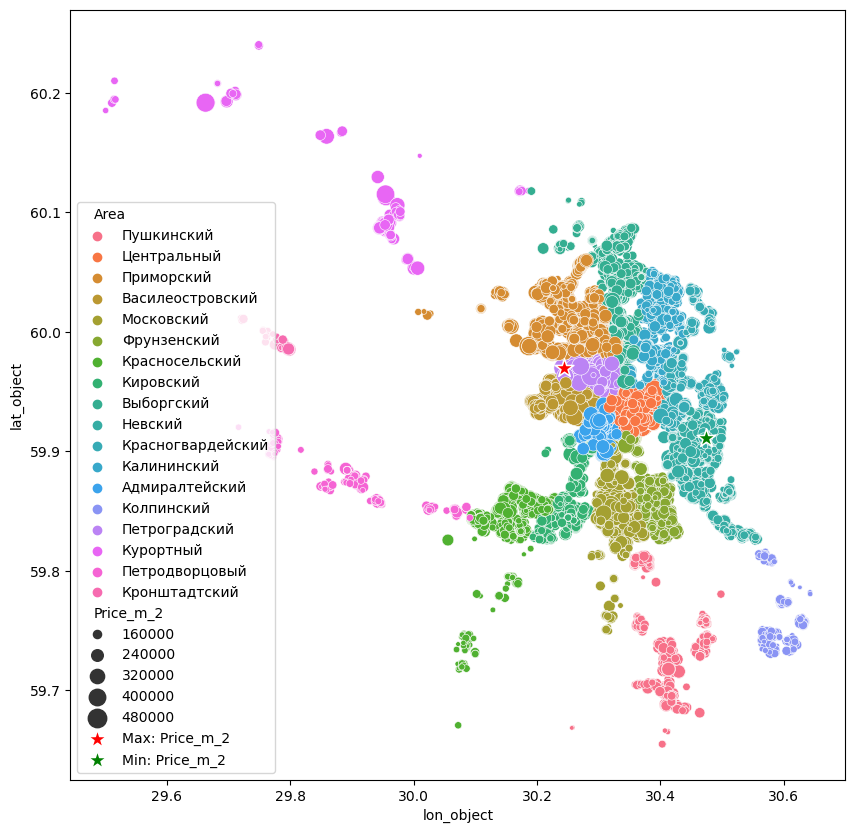

In [27]:
map_objects('Price_m_2', 'Area')

Построим еще сводную таблицу по средней стоимости квадратного метра в каждом районе.

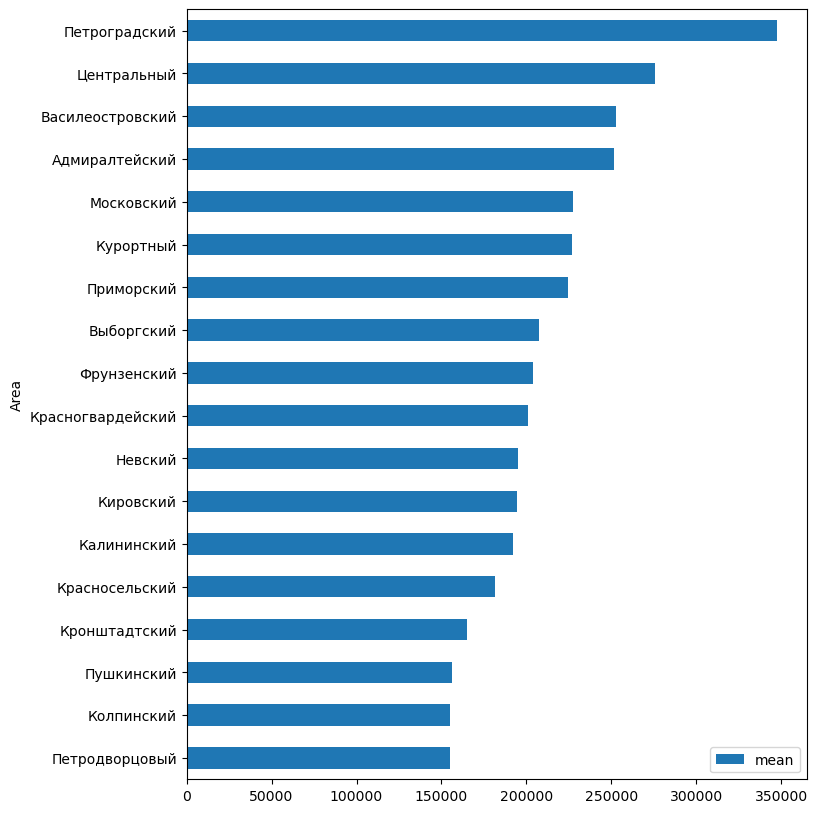

In [28]:
total = df.groupby(by='Area')['Price_m_2'].agg({'mean'}).sort_values(by='mean').plot(figsize=(8,10), kind="barh")
plt.show(total)

Самая дорогая площадь находится в Петроградском районе, а самая дешевая - в Пушкинском. В качестве центра можно использовать координаты метро Крестовский остров. Однако расчет расстояния объекта до указанной станции выполнен в предыдущем разделе.

В этой связи, дополнительный расчет до центра вводить не будем.

Введение координат до каждой станции метро позволяет исключить из рассмотрения признаки Района и ВМО

In [29]:
df = df.drop(['WMO', 'Area'], axis=1)

## Обработка признаков с большим перечнем значений

В некоторых признаках встречаются повторяющиеся значения. Введем их кодирование разделением на новые признаки со значением 0/1, с последующим суммирование в один признак.

In [30]:
def my_ohe(faeture_name: str):
    '''
    Find the longest feature in column with FEATURE_NAME 
    and separate it in the list FEATURES_SEP.
    Following create the TEMP table with columns named 
    by each faeture in FEATURES_SEP and in all rows compare FEATURE_NAME 
    with each faeture in FEATURES_SEP, then mark 1 in case they match and 0 opposite
    Return convolusion by rows of the TEMP
    '''
    features = df[faeture_name].unique().tolist()
    num_of_sym = [len(str(x)) for x in features]
    features_sep = str(features[num_of_sym.index(max(num_of_sym))]).split(', ') 
    temp = pd.DataFrame()

    def mask(row, feature:list):
        if feature in str(row[faeture_name]).split(', '):
            return 1
        return 0
        
    for feature in features_sep:
        temp[faeture_name + '_' + feature] = df.apply(mask, args=[feature], axis=1)

    df[faeture_name + '_convoul'] = temp.sum(axis=1)

In [31]:
large_features = [
        'Balcony', 'Deal_type', 'In_house', 'Yard', 
        'Furniture', 'Windows', 'Parking', 'Bathroom', 
        'Appliances', 'Room_type'
           ]
                  
for i in large_features:
    my_ohe(i)

In [32]:
df = df.drop(large_features, axis=1)
df.head()

,Price,Publication_date,Num_of_rooms,Total_area,Floor,Ceiling_height,Repair,Warm_floor,Decoration,Sale_method,...,Balcony_convoul,Deal_type_convoul,In_house_convoul,Yard_convoul,Furniture_convoul,Windows_convoul,Parking_convoul,Bathroom_convoul,Appliances_convoul,Room_type_convoul
0,9800000,17.10.2022 в 10:16,3,73.0,1 из 5,NaN,косметический,NaN,NaN,свободная,...,1,0,0,1,0,3,0,1,0,1
1,24000000,17.10.2022 в 01:22,3,85.0,3 из 5,NaN,дизайнерский,NaN,NaN,свободная,...,0,0,0,1,0,2,1,1,0,1
2,12500000,22.10.2022 в 10:29,2,55.0,8 из 12,2.6,требует ремонта,NaN,NaN,альтернативная,...,1,0,1,0,1,1,1,1,0,1
3,14200000,21.10.2022 в 16:53,1,50.0,17 из 17,3.4,требует ремонта,NaN,NaN,альтернативная,...,1,0,1,2,0,0,2,1,0,0
4,5500000,16.10.2022 в 03:52,студия,26.0,9 из 25,2.7,косметический,NaN,NaN,свободная,...,1,1,1,2,3,2,1,1,2,0


## Обработка временных признаков

В столбце с датой публикации использованы разные способы записи дат. Исправим переименованием, исключим время и сохраним месяц публикации (поможет в дальнейшем при пополнении базы объявлений и выделении сезонности).

In [33]:
date_rename = {
    'января':'.01.2022',
    'февраля':'.02.2022',
    'марта':'.03.2022',
    'апреля':'.04.2022',
    'мая':'.05.2022',
    'июня':'.06.2022',
    'июля':'.07.2022',
    'августа':'.08.2022',
    'сентября':'.09.2022',
    'октября':'.10.2022',
    'ноября':'.11.2022',
    'декабря':'.12.2022',
}

dates = df['Publication_date'].str.split(' в ', expand=True)[0]
dates = dates.str.split(' ', expand=True).replace(date_rename)
dates = dates.fillna('')

df['Publication_date'] = dates[0] + dates[1]

In [34]:
# for i in range(df.shape[0]):
#     cell_date = str(df.iloc[i]['Publication_date'])
#     if len(cell_date) != 10:
#         df.iloc[i]['Publication_date'] = '0' + cell_date

df['Publication_date_parsed'] = pd.to_datetime(df['Publication_date'], format='%d.%m.%Y')
df['Publication_month'] = df['Publication_date_parsed'].dt.month
df.head()

,Price,Publication_date,Num_of_rooms,Total_area,Floor,Ceiling_height,Repair,Warm_floor,Decoration,Sale_method,...,In_house_convoul,Yard_convoul,Furniture_convoul,Windows_convoul,Parking_convoul,Bathroom_convoul,Appliances_convoul,Room_type_convoul,Publication_date_parsed,Publication_month
0,9800000,17.10.2022,3,73.0,1 из 5,NaN,косметический,NaN,NaN,свободная,...,0,1,0,3,0,1,0,1,2022-10-17,10
1,24000000,17.10.2022,3,85.0,3 из 5,NaN,дизайнерский,NaN,NaN,свободная,...,0,1,0,2,1,1,0,1,2022-10-17,10
2,12500000,22.10.2022,2,55.0,8 из 12,2.6,требует ремонта,NaN,NaN,альтернативная,...,1,0,1,1,1,1,0,1,2022-10-22,10
3,14200000,21.10.2022,1,50.0,17 из 17,3.4,требует ремонта,NaN,NaN,альтернативная,...,1,2,0,0,2,1,0,0,2022-10-21,10
4,5500000,16.10.2022,студия,26.0,9 из 25,2.7,косметический,NaN,NaN,свободная,...,1,2,3,2,1,1,2,0,2022-10-16,10


In [35]:
df['Publication_date'] = df['Publication_date_parsed']

Используя Срок_сдачи и Год_постройки рассчитаем возраст постройки. Отрицательные значения будут соответствовать неоконченному строительству.

In [36]:
row = df.copy()
i = 0
current_year = row.iloc[i]['Publication_date'].year

In [37]:
row.iloc[i]['Due_date']

nan

In [38]:

# current_year = row[0]['Publication_date'].year
if row.iloc[i]['Due_date'] == 'сдан':
    print(0)
if not pd.isnull(row.iloc[i]['Due_date']):    
    if re.search('\d\d\d\d', row.iloc[i]['Due_date']):
        print(current_year - int(re.search('\d\d\d\d', row.iloc[i]['Срок_сдачи'])[0]))

if type(row.iloc[i]['Year_build']) == (float):
    if row.iloc[i]['Year_build'] < 100:
        print(current_year - (int(row.iloc[i]['Year_build']) + 1900))
    
    if row.iloc[i]['Year_build'] < 300:
        print(current_year - (int(row.iloc[i]['Year_build']) - 200 + 2000))
    
    print(current_year - int(row.iloc[i]['Year_build']))

In [39]:
def date_repairer(row):
    current_year = row['Publication_date'].year
    if row['Due_date'] == 'сдан':
        return 0
    if not pd.isnull(row['Due_date']):
        if re.search('\d\d\d\d', row['Due_date']):
            return current_year - int(re.search('\d\d\d\d', row['Due_date'])[0])
    if type(row['Year_build']) == (float):
        if row['Year_build'] < 100:
            return current_year - (int(row['Year_build']) + 1900)
        if row['Year_build'] < 300:
            return current_year - (int(row['Year_build']) - 200 + 2000)
        
        if pd.isnull(row['Year_build']):
            yb = 0
        else: yb = int(row['Year_build'])
        return current_year - yb
    return 'no_info'

In [40]:
df['Years_house'] = df.apply(date_repairer, axis=1)
t = df[df['Years_house'] != 'no_info']

df = df.drop(t[t['Years_house'] > 300].index, axis=0) #Удалим оставшийся мусор

In [41]:
df = df.drop(['Year_build', 'Due_date', 'Publication_date'], axis=1)

## Категориальные признаки

Сделаем функцию, которая создает новый признак со значениями 0/1, соответствующим значению no_info в исходном признаке. При этом в исходном заменяются соответствующие значения на 0.

In [42]:
def make_me_continues(feature_name):
    new_feature = feature_name + '_no_info'
    df[new_feature] = 0
    df.loc[df[feature_name] == 'no_info', new_feature] = 1

    df[feature_name] = df[feature_name].replace({
        'no_info': 0,
        'нет': 0,
        'студия': 0, 
        'свободная планировка': 0,
        '10 и больше': 10,
        'есть': 1
        })
    
    df[feature_name] = df[feature_name].astype('int')
     

In [43]:
features_continues = [
    'Cargo_lift', 
    'Passenger_lift', 
    'Num_of_rooms',
    'Years_house',
    'Warm_floor'
    ]

df[features_continues] = df[features_continues].fillna('no_info')

In [44]:
for i in features_continues:
    make_me_continues(i)  

In [45]:
df.head()

,Price,Num_of_rooms,Total_area,Floor,Ceiling_height,Repair,Warm_floor,Decoration,Sale_method,House_type,...,Appliances_convoul,Room_type_convoul,Publication_date_parsed,Publication_month,Years_house,Cargo_lift_no_info,Passenger_lift_no_info,Num_of_rooms_no_info,Years_house_no_info,Warm_floor_no_info
0,9800000,3,73.0,1 из 5,NaN,косметический,0,NaN,свободная,кирпичный,...,0,1,2022-10-17,10,10,1,1,0,0,1
2,12500000,2,55.0,8 из 12,2.6,требует ремонта,0,NaN,альтернативная,панельный,...,0,1,2022-10-22,10,30,0,0,0,0,1
3,14200000,1,50.0,17 из 17,3.4,требует ремонта,0,NaN,альтернативная,монолитный,...,0,0,2022-10-21,10,13,0,0,0,0,1
4,5500000,0,26.0,9 из 25,2.7,косметический,0,NaN,свободная,монолитный,...,2,0,2022-10-16,10,14,1,1,0,0,1
5,8500000,3,62.0,1 из 9,NaN,требует ремонта,0,NaN,альтернативная,панельный,...,0,2,2022-10-18,10,53,1,0,0,0,1


## Обработка этажей

In [46]:
df['Floor'] = df['Floor'].replace({'no_info': 0})
df.loc[df['Floor'] != 0, 'Floor'] = df['Floor'].str.split(' ', expand=True)[0]
df['Floor'] = df['Floor'].astype('int')

In [47]:
df = df.drop('Floors_in_house', axis=1)

In [48]:
phik_matrix = df.phik_matrix()

interval columns not set, guessing: ['Price', 'Num_of_rooms', 'Total_area', 'Floor', 'Ceiling_height', 'Warm_floor', 'Passenger_lift', 'Cargo_lift', 'lat_object', 'lon_object', 'комендантский проспект_dist', 'крестовский остров_dist', 'шушары_dist', 'парнас_dist', 'купчино_dist', 'улица дыбенко_dist', 'девяткино_dist', 'проспект ветеранов_dist', 'Price_m_2', 'Balcony_convoul', 'Deal_type_convoul', 'In_house_convoul', 'Yard_convoul', 'Furniture_convoul', 'Windows_convoul', 'Parking_convoul', 'Bathroom_convoul', 'Appliances_convoul', 'Room_type_convoul', 'Publication_month', 'Years_house', 'Cargo_lift_no_info', 'Passenger_lift_no_info', 'Num_of_rooms_no_info', 'Years_house_no_info', 'Warm_floor_no_info']


D:\Python\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable Num_of_rooms_no_info for analysis 1. Dropping this column
  warnings.warn(
D:\Python\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable Years_house_no_info for analysis 1. Dropping this column
  warnings.warn(


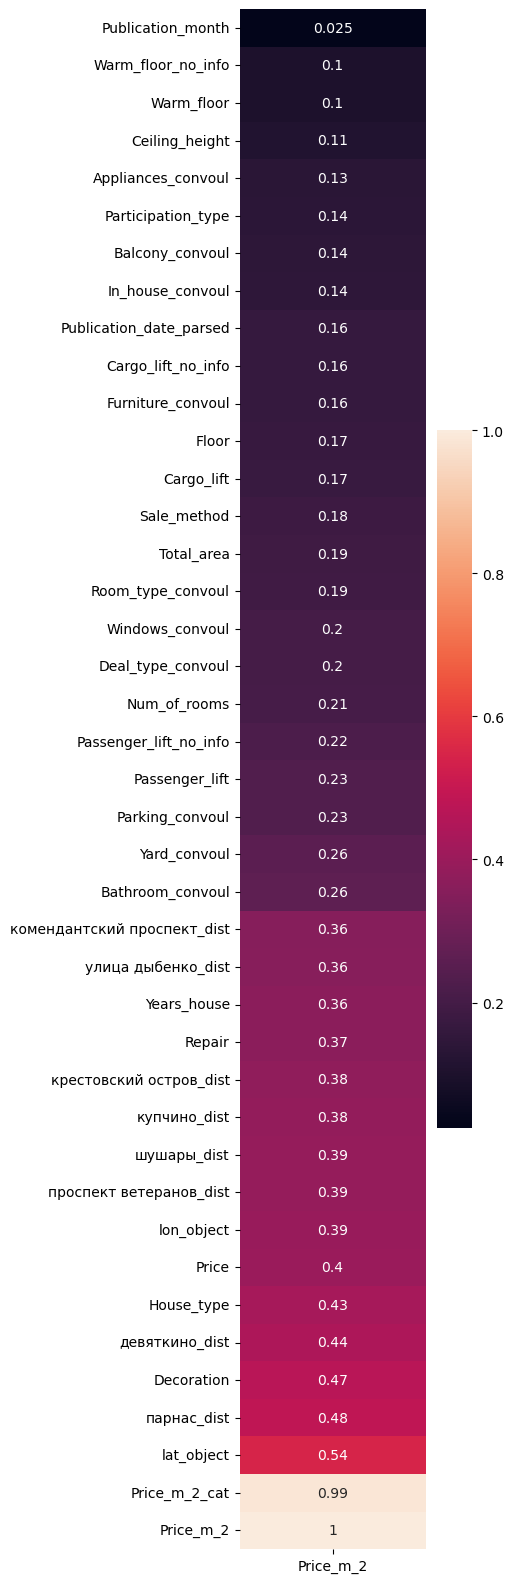

In [49]:
y = ['Price_m_2']

plt.figure(figsize=(3, 20))
sns.heatmap(phik_matrix[y].sort_values(by=y), annot=True)
plt.show()

In [50]:
# Исключаем все признаки с корреляцией  меньше 0.1
X_phik = phik_matrix[phik_matrix['Price_m_2'] > 0.1]['Price_m_2'].index.tolist()

df = df[X_phik]

In [51]:
df.head()

,Price,Num_of_rooms,Total_area,Floor,Ceiling_height,Repair,Decoration,Sale_method,House_type,Passenger_lift,...,Furniture_convoul,Windows_convoul,Parking_convoul,Bathroom_convoul,Appliances_convoul,Room_type_convoul,Publication_date_parsed,Years_house,Cargo_lift_no_info,Passenger_lift_no_info
0,9800000,3,73.0,1,NaN,косметический,NaN,свободная,кирпичный,0,...,0,3,0,1,0,1,2022-10-17,10,1,1
2,12500000,2,55.0,8,2.6,требует ремонта,NaN,альтернативная,панельный,2,...,1,1,1,1,0,1,2022-10-22,30,0,0
3,14200000,1,50.0,17,3.4,требует ремонта,NaN,альтернативная,монолитный,1,...,0,0,2,1,0,0,2022-10-21,13,0,0
4,5500000,0,26.0,9,2.7,косметический,NaN,свободная,монолитный,0,...,3,2,1,1,2,0,2022-10-16,14,1,1
5,8500000,3,62.0,1,NaN,требует ремонта,NaN,альтернативная,панельный,1,...,0,2,1,1,0,2,2022-10-18,53,1,0


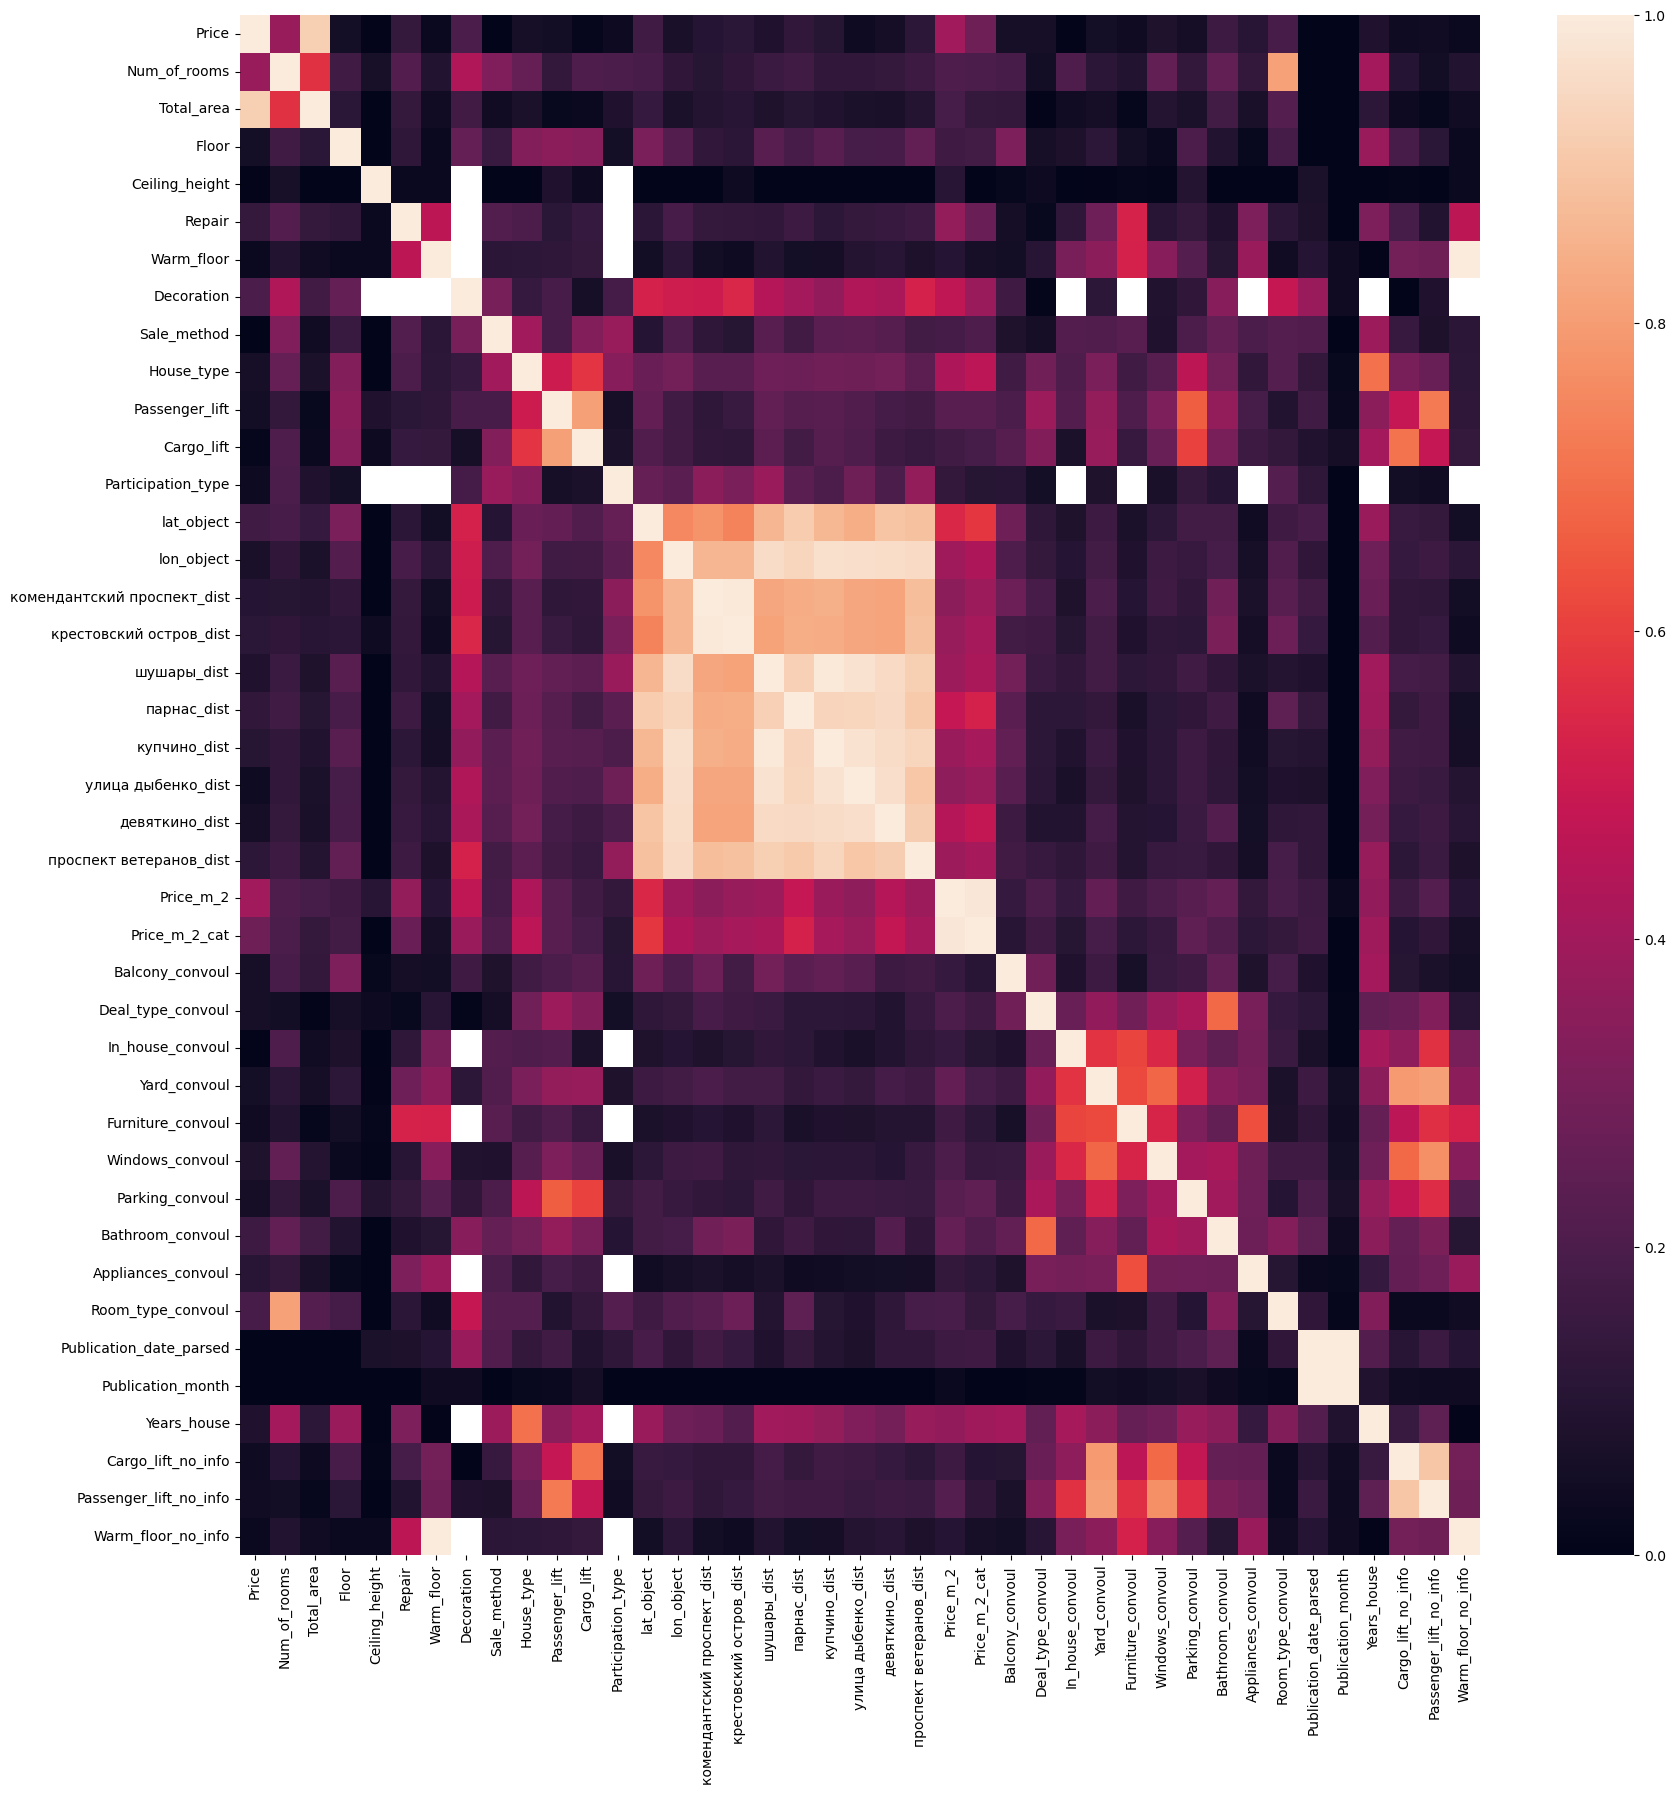

In [52]:
# смотрим на  полную матрицу корреляции

plt.figure(figsize=(20, 20))
sns.heatmap(phik_matrix)
plt.show()

Сильная мультиколлинеарность. Использовать линейные модели нельзя.

In [53]:
# сохраним датафрейм
df.to_csv('df_engineering_new.csv', index=False)